# Entrega 3 Machine Learning para IA - Kaggle Submission

### Ramiro Sanes (368397) y Joaquin Guerra (307854)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import joblib
import imageio.v2 as imageio

from tqdm import tqdm
from random import sample
import seaborn as sns

from skimage import data, color
from skimage.transform import resize

from skimage import exposure

from skimage import exposure

from sklearn.feature_extraction.image import PatchExtractor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

from utils import extract_patches
from skimage import data, color, feature

plt.style.use('ggplot')

## Tarea 1

Generar un conjunto de datos con imagenes de fondo (sin rostros)

In [2]:
images = []

# Creamos el directorio de Background si no existe
if not os.path.exists('Background'):
    os.makedirs('Background')
    #Descargamos el archivo zip de Background
    with zipfile.ZipFile('Background.zip', 'r') as zip_ref:
        zip_ref.extractall('Background')

# Cargamos imagenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field',
        #'astronaut',
        ]

for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

# Cargamos imagenes de Background
# iteramos en todas las files de background
for file in os.listdir('Background'):
    if file.endswith('.jpg'):
        filename = os.path.join('Background', file)
        img = plt.imread(filename)
        if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
            img = color.rgb2gray(img)
        images.append(resize(img, (100,100)))

# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 150, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape


Procesando imágenes: 100%|██████████| 40/40 [00:07<00:00,  5.37it/s]


(30000, 64, 64)

## Tarea 2

Evaluar la técnica de componentes principales (PCA) para la clasificacion de rostros

In [3]:
faces = []

#Cargamos caras
if not os.path.exists('Faces'):
    os.makedirs('Faces')
    with zipfile.ZipFile('Faces.zip', 'r') as zip_ref:
        zip_ref.extractall()


all_files = os.listdir('Faces')
pgm_files = [filename for filename in all_files if filename.endswith('.pgm')]

for filename in tqdm(pgm_files):
    path = os.path.join('Faces', filename)
    image = imageio.imread(path)
    faces.append(image)

faces_array = np.stack(faces)
faces_array = faces_array / 255.0

100%|██████████| 12833/12833 [00:16<00:00, 775.33it/s]


In [4]:
  # Etiquetas para las imágenes de rostros
X_faces = faces_array
y_faces = [1] * len(X_faces)

 # Etiquetas para las imágenes de fondo
X_fondos = negative_patches
y_fondos = [0] * len(X_fondos)

# Etiquetas combinadas
X = np.vstack([X_faces,X_fondos])
y = np.hstack([y_faces,y_fondos])

In [ ]:
#Obtenemos hog features para las imagenes en X
hog_features = []
# Si existe el archivo hog_features.npy, lo cargamos
if os.path.exists('hog_features.npy'):
    hog_features = np.load('hog_features.npy')
else:
    for img in tqdm(X, desc='Extrayendo HOG features'):
        fd = feature.hog(img, visualize=False)
        hog_features.append(fd)
    #Guardamos las features en un archivo
    hog_features = np.array(hog_features)
    np.save('hog_features.npy',hog_features)



In [6]:
#Aplanamos las features
hog_features = np.vstack(hog_features)
X_flatten = np.array([im.flatten() for im in tqdm(hog_features, desc='Construyendo hog_features')])

Construyendo hog_features: 100%|██████████| 42833/42833 [00:00<00:00, 89969.73it/s]


In [7]:
pca_values = [450] # Your desired components
pca_dict = {}

for i in pca_values:
    #Hacemos PCA para cada valor de componentes (PCA no incremental)
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_flatten)
    pca_dict[i] = pca



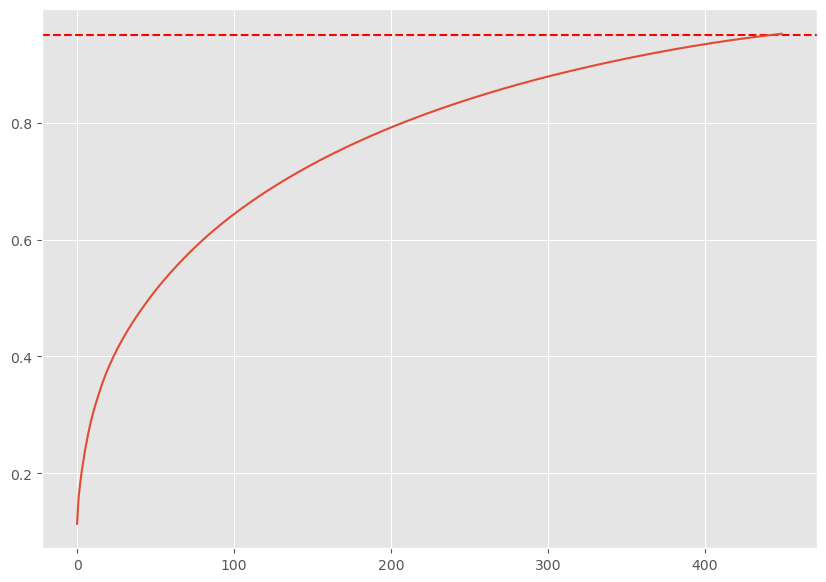

In [8]:
fig, ax = plt.subplots(1, figsize=(10, 7))
ax.axhline(y=0.95, color='r', linestyle='--', label='95%')
plt.plot(np.cumsum(pca_dict[450].explained_variance_ratio_), label=f'{450} componentes')
plt.show()

Tomamos 450 como la cantidad de componentes principales ya que pasa el umbral definido de 95% de la varianza explicada

In [9]:
pca_final = pca_dict[450]

### Visualizamos las primeras componentes

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_flatten, y, test_size=0.1, random_state=42)

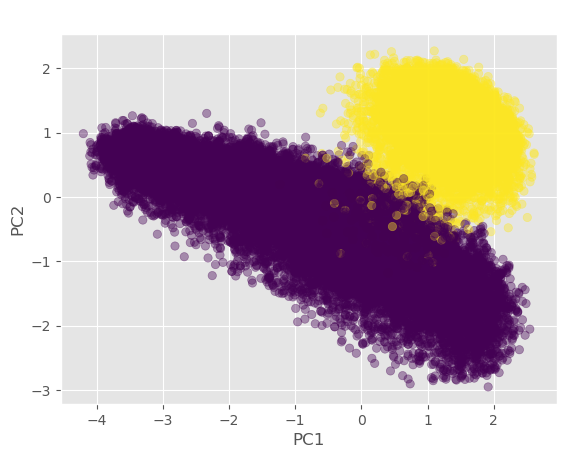

In [11]:
X_pca_train = pca_final.transform(X_train)

plt.scatter(X_pca_train[:,0], X_pca_train[:,1], alpha=0.4,c=y_train)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección')
plt.show()

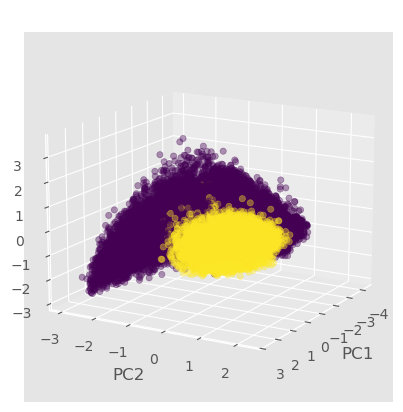

In [12]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_pca_train[:,0], X_pca_train[:,1], X_pca_train[:,2], alpha=0.4,c=y_train)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=15, azim=30)

ax.set_title('PCA - Primeras 3 componentes')
plt.show()

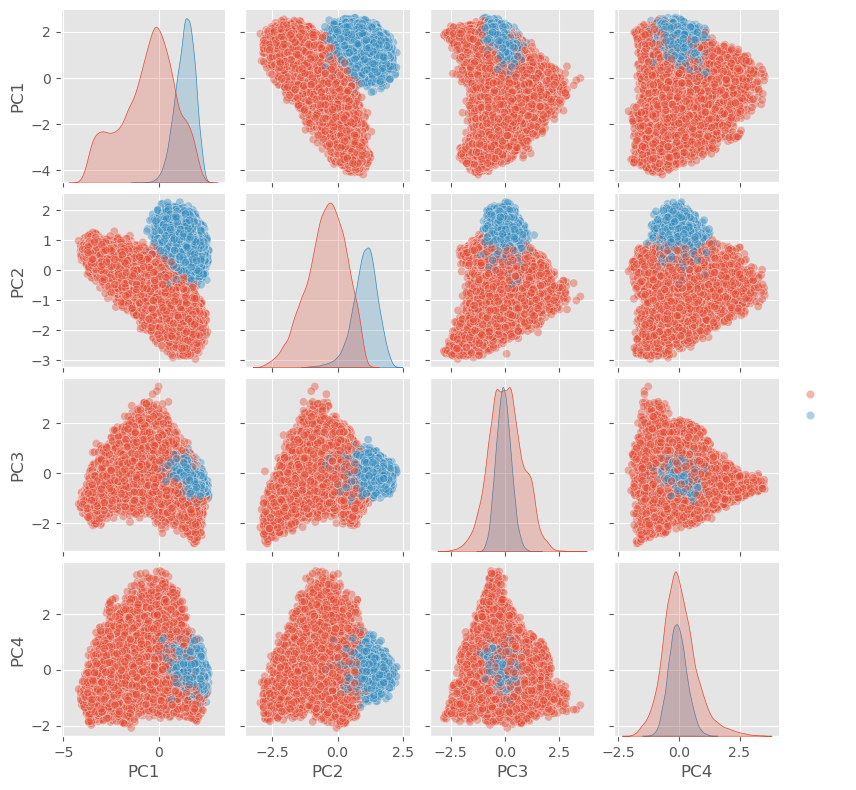

In [14]:
sns.pairplot(df, vars=['PC1','PC2','PC3','PC4'], diag_kind='kde', height=2, plot_kws={'alpha':0.4}, hue='y',)
plt.show()

### Modelo sencillo de clasificación

Entrenamos 3 árboles de decision, de profundidad 2, 5 y 10:

In [15]:
tree_dict = {}
scores = {}
for i in [2,5,10]:
    tree_dict[i] = DecisionTreeClassifier(max_depth=i,random_state=42)
    tree_dict[i].fit(X_pca_train, y_train)
    scores[i] = cross_val_score(tree_dict[i], X_pca_train, y_train, cv=5, scoring='accuracy')
    print(f"Score con {i} profundidad: {np.mean(scores[i])}")


Score con 2 profundidad: 0.9528651252204247
Score con 5 profundidad: 0.9917766977435878
Score con 10 profundidad: 0.9913097447540136


In [16]:
X_pca_val = pca_final.transform(X_val)

In [17]:
test_accuracies = {}
for i in [2,5,10]:
    test_accuracies[i] = tree_dict[i].score(X_pca_val, y_val)
    print("Accuracy en test con profundidad", i, ":", test_accuracies[i])

Accuracy en test con profundidad 2 : 0.9477124183006536
Accuracy en test con profundidad 5 : 0.9904295051353875
Accuracy en test con profundidad 10 : 0.9904295051353875


## Probamos entrenando un modelo con XGBoost (Modelo que cargamos para la Kaggle Submission)

In [18]:
# Probamos entrenando un modelo XGB y probamos en X_test_pca
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(X_pca_train, y_train)
y_pred = xgb_model.predict(X_pca_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy en test con XGB:", accuracy)

Accuracy en test con XGB: 0.996031746031746


In [34]:
# Guardamos xgb_model
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [35]:
# Guardamos el pca
joblib.dump(pca_final, 'pca_final_2025-06-08.pkl')

['pca_final_2025-06-08.pkl']